# 6.12 Assignment: Advanced Algorithms Design

Design the quantum walk operator for the case of a line with 16 modes.



**Short description of a graph:**

The described structure is a path graph consisting of 16 nodes aligned sequentially and linked in a linear topology. Each vertex connects to its immediate adjacent vertices, creating a series of edges 
(0,1),(1,2),…,(14,15).

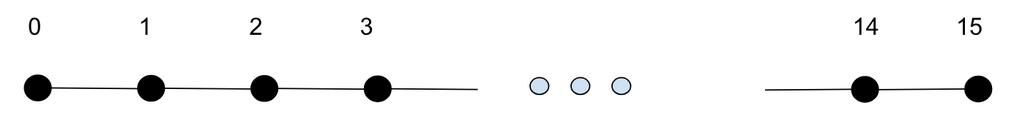

### Quantum walk algorithms: short introduction

Quantum walk algorithms are the quantum analogs of classical random walks and serve as fundamental building blocks in the design of quantum algorithms. In quantum computing, these algorithms exploit quantum superposition and entanglement to explore multiple paths simultaneously, significantly accelerating tasks like search algorithms and graph traversal. This capability allows quantum walks to perform certain computations much faster than their classical counterparts, providing a potential edge in solving complex computational problems.

In the code below, we focus on two major steps of the quantum walk algorithm (discrete-time):
1. Coin Operation: Apply a coin operator to the coin register. This quantum operation creates a combination of possible directions in which the walker can move. We will use the C operator to describe the movement probabilities.

2. Shift Operation: Apply a shift operator to the walker's position based on the state of the coin register. This operator moves the walker to new positions depending on the current state of the coin register. The quantum walker evolves under this shift operator, leading to a spread over the graph or structure that the algorithm is exploring. We will use the S operato to execute the movement.

One step of discrete-time quantum walk is describe by the unitary operator SC.


In [1]:
from classiq import *

## Coin operator

$$ C := \sum_{j\in V} |j\rangle\langle j| \otimes (2|\partial_j\rangle \langle \partial_j| - \mathbb{1}) $$


### Phase kickback
let us assume that we know the $U_j$ operator that creates the state $|\partial_j\rangle$, i.e. $U_j |0 \rangle = |\partial_j\rangle$.

Then $(2|\partial_j\rangle \langle \partial_j| - \mathbb{1}) = U_j (2 |0\rangle\langle 0| - \mathbb{1})U_j^{\dagger}$, where in the braket is the phase kickback (quantum primitieves) encoded:

$$ (2 |0\rangle\langle0| - \mathbb{1})|x\rangle = (-1)^{x\neq 0 } |x \rangle $$

In [8]:
### Implementing of the phase kickback

# Prepare the |-> state
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

# Check the phase
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)
  
# Apply phase kickback
@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

### Define a C  (coin) operator





In [60]:
# Prepare a C operator; |j><j| - U_j(2|0><0|-1)U_j^dagger
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    nodes = 2**size
    prob = [0]*nodes
    if i == 0:
       prob[i+1] = 1
    elif i == (nodes-1):
       prob[nodes-2] = 1
    else:
       prob[i-1] = 0.5
       prob[i+1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

# Apply the C operator to all vertices; sum_{j in V} W_iteration
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

### Shift operator

$$S : = \sum_{(j,k)\in E} |j,k \rangle \langle k,j| $$

Connections for 1D chain without periodic boundary conditions:
1. The first node and the last have just one connection, 0-1 and 14-15, respectively,
for system with 16 nodes.
2. Each node between the first and last has two connections, (i-1)-i and i-(i+1).

In [61]:
# Swap the QArray bit by bit |j,k><k,j|
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

# Check if two vertices are adjacent; if (j,k) in E
# if yes then return 1, otherwize return 0
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= ((vertices + 1 == adjacent_vertices) | (vertices - 1 == adjacent_vertices))

# Apply S operator
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
  res = QNum('res')
  edge_oracle(res,vertices,adjacent_vertices)
  control(ctrl= res==1,
    operand= lambda: bitwise_swap(vertices,adjacent_vertices))

### Main function: C operator + S operator

Start by initialize the walker in a superoposition of all possible states: |0>,|1>,...,|15>. Then apply the coin operator and shift operator. This two functions together constitude a one step in the quantum walk algorithm.

In [64]:
size = 4 # we need 4 qubits to simulate a graph with 16 nodes; 2^4=16

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices) # apply coin operator
  S_operator(vertices,adjacent_vertices) # apply shift operator

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 